# **Building BERT from Scratch**

In [25]:
!pip install --no-cache-dir numpy==1.26.4 pandas==2.2.1
!pip install --no-cache-dir torch==2.3.0 torchtext==0.18.0 transformers==4.35.2
!pip install --no-cache-dir matplotlib==3.9.0

In [1]:
import torch
from torch.utils.data import DataLoader
from torch import Tensor
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import Transformer
from transformers import BertTokenizer
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchtext.vocab import Vocab,build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import IMDB
import random
from itertools import chain
import pandas as pd
from copy import deepcopy
import csv
import json
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import get_linear_schedule_with_warmup

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')


/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.11/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable

## **1. Loading Data**

In [2]:
%%bash
# Remove any earlier instance of the dataset loaded
if [ -d "bert_dataset" ]; then
    rm -rf bert_dataset
fi

In [3]:
!wget -O BERT_dataset.zip https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/bZaoQD52DcMpE7-kxwAG8A.zip
!unzip BERT_dataset.zip

--2025-07-06 15:43:15--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/bZaoQD52DcMpE7-kxwAG8A.zip
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88958506 (85M) [application/zip]
Saving to: ‘BERT_dataset.zip’

BERT_dataset.zip    100%[===================>]  84.84M  55.7MB/s    in 1.5s    

2025-07-06 15:43:17 (55.7 MB/s) - ‘BERT_dataset.zip’ saved [88958506/88958506]

Archive:  BERT_dataset.zip
   creating: bert_dataset/
  inflating: bert_dataset/.DS_Store  
  inflating: bert_dataset/bert_train_data.csv  
  inflating: bert_dataset/bert_test_data_sampled.csv  
  inflating: bert_dataset/bert_test_data.csv  
  inflating: bert_dataset/bert_train_data_s

In [4]:
class BERTCSVDataset(Dataset):
    def __init__(self, filename):
        self.data = pd.read_csv(filename)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        try:

            bert_input = torch.tensor(json.loads(row['BERT Input']), dtype=torch.long)
            bert_label = torch.tensor(json.loads(row['BERT Label']), dtype=torch.long)
            segment_label = torch.tensor([int(x) for x in row['Segment Label'].split(',')], dtype=torch.long)
            is_next = torch.tensor(row['Is Next'], dtype=torch.long)
            original_text = row['Original Text']  # If you want to use it
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON for row {idx}: {e}")
            print("BERT Input:", row['BERT Input'])
            print("BERT Label:", row['BERT Label'])
            # Handle the error, e.g., by skipping this row or using default values
            return None  # or some default values

            # Tokenizing the original text with BERT
        encoded_input = self.tokenizer.encode_plus(
            original_text,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        input_ids = encoded_input['input_ids'].squeeze()
        attention_mask = encoded_input['attention_mask'].squeeze()

        return(bert_input, bert_label, segment_label, is_next, input_ids, attention_mask, original_text)

In [5]:
PAD_IDX = 0
def collate_batch(batch):


    bert_inputs_batch, bert_labels_batch, segment_labels_batch, is_nexts_batch,input_ids_batch,attention_mask_batch,original_text_battch = [], [], [], [],[],[],[]

    for bert_input, bert_label, segment_label, is_next,input_ids,attention_mask,original_text in batch:
        # Convert each sequence to a tensor and append to the respective list
        bert_inputs_batch.append(torch.tensor(bert_input, dtype=torch.long))
        bert_labels_batch.append(torch.tensor(bert_label, dtype=torch.long))
        segment_labels_batch.append(torch.tensor(segment_label, dtype=torch.long))
        is_nexts_batch.append(is_next)
        input_ids_batch.append(input_ids)
        attention_mask_batch.append(attention_mask)
        original_text_battch.append(original_text)

    # Pad the sequences in the batch
    bert_inputs_final = pad_sequence(bert_inputs_batch, padding_value=PAD_IDX, batch_first=False)
    bert_labels_final = pad_sequence(bert_labels_batch, padding_value=PAD_IDX, batch_first=False)
    segment_labels_final = pad_sequence(segment_labels_batch, padding_value=PAD_IDX, batch_first=False)
    is_nexts_batch = torch.tensor(is_nexts_batch, dtype=torch.long)

    return bert_inputs_final, bert_labels_final, segment_labels_final, is_nexts_batch

In [6]:
# BATCH_SIZE = 2

# train_dataset_path = './bert_dataset/bert_train_data.csv'
# test_dataset_path = './bert_dataset/bert_test_data.csv'

# train_dataset = BERTCSVDataset(train_dataset_path)
# test_dataset = BERTCSVDataset(test_dataset_path)

# train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
# test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

## The DataLoader above is quite huge, and it will take several hours for the model to train with such a huge dataset.
## Hence, below is the randomly sampled dataset (which is relatively small) from IMDB to make the process faster.

BATCH_SIZE = 3

train_dataset_path = './bert_dataset/bert_train_data_sampled.csv'
test_dataset_path = './bert_dataset/bert_test_data_sampled.csv'

train_dataset = BERTCSVDataset(train_dataset_path)
test_dataset = BERTCSVDataset(test_dataset_path)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## **2. Model Creation**

In [7]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)


# Define the PositionalEncoding class as a PyTorch module for adding positional information to token embeddings
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        # Create a positional encoding matrix as per the Transformer paper's formula
        den = torch.exp(- torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)
    def forward(self, token_embedding: torch.Tensor):
        # Apply the positional encodings to the input token embeddings
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])


class BERTEmbedding (nn.Module):
    def __init__(self, vocab_size, emb_size ,dropout=0.1,train=True):
        super().__init__()
        self.token_embedding = TokenEmbedding( vocab_size,emb_size )
        self.positional_encoding = PositionalEncoding(emb_size,dropout)
        self.segment_embedding = nn.Embedding(3, emb_size)
        self.dropout = torch.nn.Dropout(p=dropout)
    def forward(self, bert_inputs, segment_labels=False):
        my_embeddings = self.token_embedding(bert_inputs)
        if self.train:
            x = self.dropout(self.positional_encoding(my_embeddings) + self.segment_embedding(segment_labels))
        else:
            x = self.positional_encoding(my_embeddings)
        return x


In [8]:
class BERT(torch.nn.Module):
    def __init__(self, vocab_size, d_model=768, n_layers=12, heads=12, dropout=0.1):
        """
        vocab_size: The size of the vocabulary.
        d_model: The size of the embeddings (hidden size).
        n_layers: The number of Transformer layers.
        heads: The number of attention heads in each Transformer layer.
        dropout: The dropout rate applied to embeddings and Transformer layers.
        """
        super().__init__()
        self.d_model = d_model
        self.n_layers = n_layers
        self.heads = heads

        # Embedding layer that combines token embeddings and segment embeddings
        self.bert_embedding = BERTEmbedding(vocab_size, d_model, dropout)
        # Transformer Encoder layers
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=heads, dropout=dropout,batch_first=False)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=n_layers)
        # Linear layer for Next Sentence Prediction
        self.nextsentenceprediction = nn.Linear(d_model, 2)
        # Linear layer for Masked Language Modeling
        self.masked_language = nn.Linear(d_model, vocab_size)

    def forward(self, bert_inputs, segment_labels):
        """
        bert_inputs: Input tokens.
        segment_labels: Segment IDs for distinguishing different segments in the input.
        mask: Attention mask to prevent attention to padding tokens.

        return: Predictions for next sentence task and masked language modeling task.
        """
        padding_mask = (bert_inputs == PAD_IDX).transpose(0, 1)
        # Generate embeddings from input tokens and segment labels
        my_bert_embedding = self.bert_embedding(bert_inputs, segment_labels)
        # Pass embeddings through the Transformer encoder
        transformer_encoder_output = self.transformer_encoder(my_bert_embedding,src_key_padding_mask=padding_mask)
        next_sentence_prediction = self.nextsentenceprediction(transformer_encoder_output[ 0,:])
        # Masked Language Modeling: Predict all tokens in the sequence
        masked_language = self.masked_language(transformer_encoder_output)
        return  next_sentence_prediction, masked_language

In [9]:
vocab_size = 147161
EMBEDDING_DIM = 10
d_model = EMBEDDING_DIM
n_layers = 2
initial_heads = 12
initial_heads = 2
heads = initial_heads - d_model % initial_heads

dropout = 0.1  # Dropout rate

# Create an instance of the BERT model
model = BERT(vocab_size, d_model, n_layers, heads, dropout)

## **3. Evaluation Function**

In [10]:
PAD_IDX=0
loss_fn_mlm = nn.CrossEntropyLoss(ignore_index=PAD_IDX)# The loss function must ignore PAD tokens and only calculates loss for the masked tokens
loss_fn_nsp = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
device

device(type='cuda')

In [11]:
def evaluate(dataloader=test_dataloader, model=model, loss_fn_mlm=loss_fn_mlm, loss_fn_nsp=loss_fn_nsp, device=device):
    model.eval()  # Turn off dropout and other training-specific behaviors

    total_loss = 0
    total_next_sentence_loss = 0
    total_mask_loss = 0
    total_batches = 0
    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for batch in dataloader:
            bert_inputs, bert_labels, segment_labels, is_nexts = [b.to(device) for b in batch]

            # Forward pass
            next_sentence_prediction, masked_language = model(bert_inputs, segment_labels)

            # Calculate loss for next sentence prediction
            # Ensure is_nexts is of the correct shape for CrossEntropyLoss
            next_loss = loss_fn_nsp(next_sentence_prediction, is_nexts.view(-1))

            # Calculate loss for predicting masked tokens
            # Flatten both masked_language predictions and bert_labels to match CrossEntropyLoss input requirements
            mask_loss = loss_fn_mlm(masked_language.view(-1, masked_language.size(-1)), bert_labels.view(-1))

            # Sum up the two losses
            loss = next_loss + mask_loss
            if torch.isnan(loss):
                continue
            else:
                total_loss += loss.item()
                total_next_sentence_loss += next_loss.item()
                total_mask_loss += mask_loss.item()
                total_batches += 1

    avg_loss = total_loss / (total_batches + 1)
    avg_next_sentence_loss = total_next_sentence_loss / (total_batches + 1)
    avg_mask_loss = total_mask_loss / (total_batches + 1)

    print(f"Average Loss: {avg_loss:.4f}, Average Next Sentence Loss: {avg_next_sentence_loss:.4f}, Average Mask Loss: {avg_mask_loss:.4f}")
    return avg_loss

## **4. Training**

In [12]:
# Define the optimizer
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=0.01, betas=(0.9, 0.999))

# Training loop setup
num_epochs = 5
total_steps = num_epochs * len(train_dataloader)

# Define the number of warmup steps, e.g., 10% of total
warmup_steps = int(total_steps * 0.1)

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps)

# Lists to store losses for plotting
train_losses = []
eval_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")):
        bert_inputs, bert_labels, segment_labels, is_nexts = [b.to(device) for b in batch]

        optimizer.zero_grad()
        next_sentence_prediction, masked_language = model(bert_inputs, segment_labels)

        next_loss = loss_fn_nsp(next_sentence_prediction, is_nexts)
        mask_loss = loss_fn_mlm(masked_language.view(-1, masked_language.size(-1)), bert_labels.view(-1))

        loss = next_loss + mask_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()  # Update the learning rate

        total_loss += loss.item()

        if torch.isnan(loss):
            continue
        else:
            total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader) + 1
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1} - Average training loss: {avg_train_loss:.4f}")

    # Evaluation after each epoch
    eval_loss = evaluate(test_dataloader, model, loss_fn_nsp, loss_fn_mlm, device)
    eval_losses.append(eval_loss)

Epoch 1: 100%|██████████| 3334/3334 [01:46<00:00, 31.34it/s]


Epoch 1 - Average training loss: 25.7529
Average Loss: 12.3215, Average Next Sentence Loss: 0.6074, Average Mask Loss: 11.7141


Epoch 2: 100%|██████████| 3334/3334 [01:43<00:00, 32.20it/s]


Epoch 2 - Average training loss: 24.0157
Average Loss: 12.4446, Average Next Sentence Loss: 0.7045, Average Mask Loss: 11.7401


Epoch 3: 100%|██████████| 3334/3334 [01:43<00:00, 32.17it/s]


Epoch 3 - Average training loss: 22.6847
Average Loss: 12.4571, Average Next Sentence Loss: 0.6823, Average Mask Loss: 11.7747


Epoch 4: 100%|██████████| 3334/3334 [01:43<00:00, 32.15it/s]


Epoch 4 - Average training loss: 22.1186
Average Loss: 12.4500, Average Next Sentence Loss: 0.6568, Average Mask Loss: 11.7931


Epoch 5: 100%|██████████| 3334/3334 [01:43<00:00, 32.20it/s]


Epoch 5 - Average training loss: 21.9311
Average Loss: 12.4761, Average Next Sentence Loss: 0.6762, Average Mask Loss: 11.7999


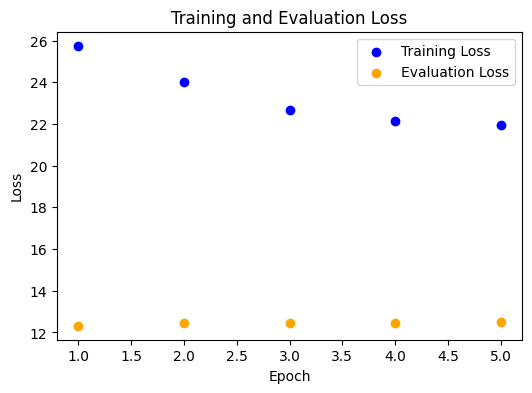

In [13]:
plt.figure(figsize=(6, 4))
plt.scatter(range(1,num_epochs+1), train_losses, label="Training Loss", color='blue')
plt.scatter(range(1,num_epochs+1), eval_losses, label="Evaluation Loss", color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.show()

## **5. Inference**

In [14]:
model1 = BERT(vocab_size, d_model, n_layers, heads, dropout)  # Ensure these parameters match the original model's
!wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/H04Cs7O75aOfmJ4YP2HdPw.pt'
model1.load_state_dict(torch.load('H04Cs7O75aOfmJ4YP2HdPw.pt',map_location=torch.device('cpu')))
model1.to(device)

--2025-07-06 15:55:35--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/H04Cs7O75aOfmJ4YP2HdPw.pt
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13099721 (12M) [binary/octet-stream]
Saving to: ‘H04Cs7O75aOfmJ4YP2HdPw.pt’

H04Cs7O75aOfmJ4YP2H 100%[===================>]  12.49M  24.5MB/s    in 0.5s    

2025-07-06 15:55:36 (24.5 MB/s) - ‘H04Cs7O75aOfmJ4YP2HdPw.pt’ saved [13099721/13099721]



BERT(
  (bert_embedding): BERTEmbedding(
    (token_embedding): TokenEmbedding(
      (embedding): Embedding(147161, 10)
    )
    (positional_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (segment_embedding): Embedding(3, 10)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=True)
    )
    (linear1): Linear(in_features=10, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=10, bias=True)
    (norm1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x Tran

In [15]:
def predict_nsp(sentence1, sentence2, model, tokenizer):
    # Tokenize sentences with special tokens
    tokens = tokenizer.encode_plus(sentence1, sentence2, return_tensors="pt")
    tokens_tensor = tokens["input_ids"].to(device)
    segment_tensor = tokens["token_type_ids"].to(device)

    # Predict
    with torch.no_grad():
        # Assuming the model returns NSP predictions first
        nsp_prediction, _ = model(tokens_tensor, segment_tensor)
        # Select the first element (first sequence) of the logits tensor
        first_logits = nsp_prediction[0].unsqueeze(0)  # Adds an extra dimension, making it [1, 2]
        logits = torch.softmax(first_logits, dim=1)
        prediction = torch.argmax(logits, dim=1).item()

    # Interpret the prediction
    return "Second sentence follows the first" if prediction == 1 else "Second sentence does not follow the first"

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model1.eval()

sentence1 = "The cat sat on the mat."
sentence2 = "It was a sunny day"

print(predict_nsp(sentence1, sentence2, model1, tokenizer))

Second sentence follows the first


In [16]:
model.eval()
print(predict_nsp(sentence1, sentence2, model, tokenizer))

Second sentence follows the first


In [21]:
def predict_mlm(sentence, model, tokenizer):
    device = next(model.parameters()).device
    # Tokenize the input sentence and convert to token IDs, including special tokens
    inputs = tokenizer(sentence, return_tensors="pt")
    tokens_tensor = inputs.input_ids.to(device)

    # Create dummy segment labels filled with zeros, assuming it's needed by your model
    segment_labels = torch.zeros_like(tokens_tensor).to(device)

    with torch.no_grad():
        # Forward pass through the model, now correctly handling the output tuple
        output_tuple = model(tokens_tensor, segment_labels)

        # Assuming the second element of the tuple contains the MLM logits
        predictions = output_tuple[1]  # Adjusted based on your model's output

        # Identify the position of the [MASK] token
        mask_token_index = (tokens_tensor == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]

        # Get the predicted index for the [MASK] token from the MLM logits
        predicted_index = torch.argmax(predictions[0, mask_token_index.item(), :], dim=-1)
        predicted_token = tokenizer.convert_ids_to_tokens([predicted_index.item()])[0]

        # Replace [MASK] in the original sentence with the predicted token
        predicted_sentence = sentence.replace(tokenizer.mask_token, predicted_token, 1)

    return predicted_sentence

model1.eval()
sentence = "The cat sat on the [MASK]."
print(predict_mlm(sentence, model1, tokenizer))

The cat sat on the [unused8].


In [22]:
model.eval()
print(predict_mlm(sentence, model, tokenizer))

The cat sat on the [unused4].


## NSP and MLM using BertForPreTraining (`bert-base-uncased`)

In [23]:
from transformers import BertForPreTraining, BertTokenizer
import torch


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForPreTraining.from_pretrained('bert-base-uncased')

text_1 = "The cat sat on the mat"
text_2 = "It was a sunny day"
inputs = tokenizer(text_1, text_2, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs, next_sentence_label=torch.LongTensor([1]))
    nsp_logits = outputs.seq_relationship_logits

if torch.argmax(nsp_logits, dim=-1).item() == 0:
    print("The model thinks these sentences are NOT consecutive.")
else:
    print("The model thinks these sentences are consecutive.")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

The model thinks these sentences are NOT consecutive.


In [24]:
masked_text = "The capital of France is [MASK]."
input_ids = tokenizer(masked_text, return_tensors="pt")["input_ids"]

with torch.no_grad():
    outputs = model(input_ids=input_ids)
    predictions = outputs.prediction_logits

predicted_index = torch.argmax(predictions[0, input_ids[0] == tokenizer.mask_token_id]).item()
predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])

print(f"Predicted token: {predicted_token}")

Predicted token: ['paris']
